# **Part A**
Count / Frequency based Naive Bayes Classifier

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)
from scipy.sparse import issparse # Needed for feature vector checks



# Data loading function (DO NOT CHANGE)
def load_pubmed_rct_file(filepath):
    """
    Reads a .txt file from the PubMed 20k RCT dataset.
    Returns a DataFrame with 'label' and 'sentence'.
    """
    labels, sentences = [], []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line or '\t' not in line:
                continue
            label, sent = line.split('\t', maxsplit=1)
            labels.append(label)
            sentences.append(sent)
    return pd.DataFrame({'label': labels, 'sentence': sentences})


# Implementing Multinomial Naive Bayes from scratch
class NaiveBayesClassifier:
    """
    Multinomial Naive Bayes Classifier implemented from scratch.
    It is suitable for both Count and TF-IDF features.
    """
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.class_priors = {}
        self.feature_log_probs = {}
        self.classes = None
        self.vocabulary_size = 0

    def fit(self, X_counts, y):
        # Ensure X_counts is convertible to CSR matrix for efficient row slicing
        if not issparse(X_counts):
             X_counts = X_counts.tocsr()

        y_array = y.to_numpy()
        self.classes = np.unique(y_array)
        self.vocabulary_size = X_counts.shape[1]
        N_samples = X_counts.shape[0]

        for c in self.classes:
            X_c = X_counts[y_array == c]
            N_c = X_c.shape[0]

            # // TODO 1: Calculate the log prior and store it in self.class_priors[c]
            # Calculate Class Prior P(C): log(P(C))
            # P(C) = (Number of samples in class c) / (Total number of samples)
            self.class_priors[c] = np.log(N_c / N_samples) # Filled TODO 1

            # feature_sum is a 1D array of word counts in class c
            feature_sum = X_c.sum(axis=0).A1
            total_mass = np.sum(feature_sum) # Total word tokens in class c

            # Apply Laplace smoothing (additive smoothing, alpha=1.0 default):
            # P(w_i | C) = (count(w_i, C) + alpha) / (total_words_in_C + alpha * vocab_size)

            # // TODO 2: Calculate the numerator (with Laplace smoothing)
            numerator = feature_sum + self.alpha # Filled TODO 2

            # // TODO 3: Calculate the denominator (with Laplace smoothing)
            denominator = total_mass + self.alpha * self.vocabulary_size # Filled TODO 3

            # // TODO 4: Calculate the log likelihood (log(numerator / denominator))
            self.feature_log_probs[c] = np.log(numerator / denominator) # Filled TODO 4

    def predict(self, X_counts):
        # Ensure X_counts is convertible to CSR matrix for efficient row access
        if not issparse(X_counts):
             X_counts = X_counts.tocsr()

        y_pred = []
        for i in range(X_counts.shape[0]):
            scores = {}

            x_i = X_counts.getrow(i) # Get the i-th feature vector

            for c in self.classes:
                log_prob = self.class_priors[c]
                log_likelihoods = self.feature_log_probs[c]

                # Get feature indices and counts for the current document (only non-zero features matter)
                non_zero_indices = x_i.indices
                non_zero_data = x_i.data

                # // TODO 5: Complete the log probability calculation for the likelihood term
                # Add log likelihoods contribution (Log-Sum Trick):
                # log_prob += sum(count(w_i) * log(P(w_i|C)))

                # Multiply feature count (data) by the corresponding log likelihood (from indices)
                likelihood_contribution = np.sum(non_zero_data * log_likelihoods[non_zero_indices])
                log_prob += likelihood_contribution # Filled TODO 5
                scores[c] = log_prob

            # // TODO 6: Find the key (class label) with the maximum score
            predicted_class = max(scores, key=scores.get) # Filled TODO 6

            y_pred.append(predicted_class)

        # // TODO 7: Return the final predictions array
        return np.array(y_pred) # Filled TODO 7





In [6]:
# Load and Prepare Data (DO NOT CHANGE)
dir_path = './'
try:
    train_df = load_pubmed_rct_file(os.path.join(dir_path, 'train.txt'))
    dev_df   = load_pubmed_rct_file(os.path.join(dir_path, 'dev.txt'))
    test_df  = load_pubmed_rct_file(os.path.join(dir_path, 'test.txt'))

    # train_df = pd.DataFrame({'label': ['BACKGROUND'], 'sentence': ['placeholder']})
    # dev_df   = pd.DataFrame({'label': ['BACKGROUND'], 'sentence': ['placeholder']})
    # test_df  = pd.DataFrame({'label': ['BACKGROUND'], 'sentence': ['placeholder']})


    print(f"Train samples: {len(train_df)}")
    print(f"Dev   samples: {len(dev_df)}")
    print(f"Test  samples: {len(test_df)}")

    X_train, y_train = train_df['sentence'], train_df['label']
    X_dev,   y_dev   = dev_df['sentence'],   dev_df['label']
    X_test,  y_test  = test_df['sentence'],  test_df['label']
    target_names = sorted(y_train.unique())
    print(f"Classes: {target_names}")

except FileNotFoundError as e:
    print(f"Error: Dataset file not found. Please ensure the files are uploaded.")
    X_train, y_train = pd.Series([]), pd.Series([])
    X_test, y_test = pd.Series([]), pd.Series([])
    target_names = []

Train samples: 83405
Dev   samples: 30212
Test  samples: 30135
Classes: ['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS']


In [7]:
# Feature Extraction and Custom Model Training
if X_train is not None and len(X_train) > 0:

    # Initialize and fit the CountVectorizer for count-based features
    count_vectorizer = CountVectorizer(
        lowercase=True,
        strip_accents='unicode',
        stop_words='english',
        # Set appropriate ngram_range
        ngram_range=(1, 2),
        # Set appropriate min_df
        min_df=5,
        # *** FIX for ValueError: Explicitly set max_df to 1.0 ***
        max_df=1.0
    )

    print("Fitting Count Vectorizer and transforming training data...")
    # Fit the vectorizer on X_train and transform
    X_train_counts = count_vectorizer.fit_transform(X_train)
    if X_train_counts is not None:
        print(f"Vocabulary size: {X_train_counts.shape[1]}")

    print("Transforming test data...")
    # Transform X_test using the fitted vectorizer
    X_test_counts = count_vectorizer.transform(X_test)


    # Train Custom Naive Bayes Classifier
    print("\nTraining the Custom Naive Bayes Classifier (from scratch)...")

    # Initialize the custom NaiveBayesClassifier
    # Assumes NaiveBayesClassifier class is defined and available
    nb_model = NaiveBayesClassifier(alpha=1.0)

    # Fit the model using X_train_counts and y_train
    nb_model.fit(X_train_counts, y_train)
    print("Training complete.")

else:
    print("Skipping feature extraction and training: Training data is empty or not loaded.")

Fitting Count Vectorizer and transforming training data...
Vocabulary size: 43029
Transforming test data...

Training the Custom Naive Bayes Classifier (from scratch)...
Training complete.


In [8]:
# Predict and evaluate on test set
print("\n=== Test Set Evaluation (Custom Count-Based Naive Bayes) ===")

# // TODO: Predict y_test_pred using X_test_counts
y_test_pred = nb_model.predict(X_test_counts)

if y_test_pred is not None and len(y_test_pred) > 0: # Added length check for robustness
    print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    print(classification_report(y_test, y_test_pred, target_names=target_names))
    test_f1 = f1_score(y_test, y_test_pred, average='macro')
    print(f"Macro-averaged F1 score: {test_f1:.4f}")
else:
    print("Prediction step failed or incomplete.")



=== Test Set Evaluation (Custom Count-Based Naive Bayes) ===
Accuracy: 0.7405
              precision    recall  f1-score   support

  BACKGROUND       0.52      0.55      0.54      3621
 CONCLUSIONS       0.60      0.70      0.65      4571
     METHODS       0.82      0.85      0.84      9897
   OBJECTIVE       0.53      0.49      0.51      2333
     RESULTS       0.88      0.78      0.83      9713

    accuracy                           0.74     30135
   macro avg       0.67      0.67      0.67     30135
weighted avg       0.75      0.74      0.74     30135

Macro-averaged F1 score: 0.6708


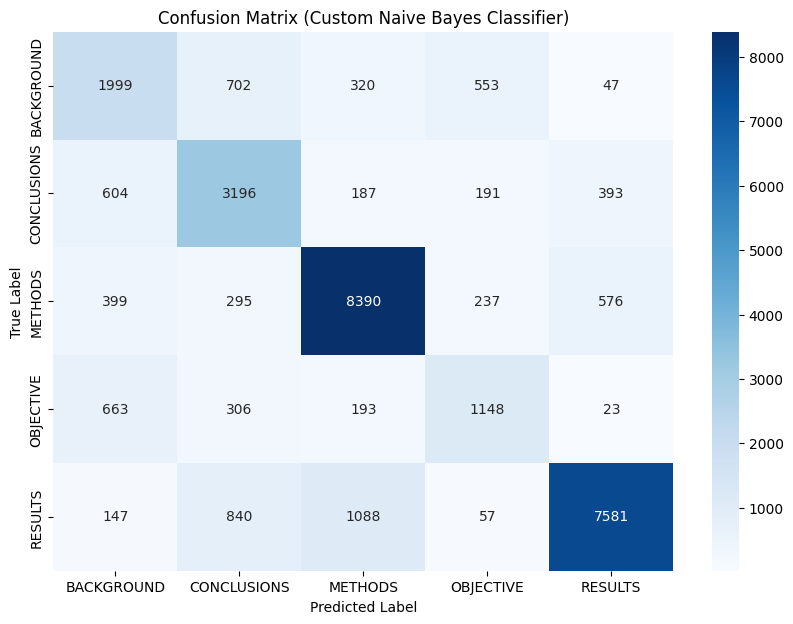

In [9]:
# Confusion Matrix on test set
# // TODO: Use the confusion_matrix, matplotlib, and seaborn libraries to generate
# a visual confusion matrix (heatmap) for the predicted results.
if y_test_pred is not None:

    # Calculate the Confusion Matrix
    # The 'labels' argument ensures the classes are ordered correctly in the matrix
    cm = confusion_matrix(y_test, y_test_pred, labels=nb_model.classes)

    # Get the class names for axis labels
    class_names = nb_model.classes # Assuming target_names or nb_model.classes holds the labels

    # Plotting the Confusion Matrix as a heatmap
    plt.figure(figsize=(10, 7))
    sns.heatmap(
        cm,
        annot=True,          # Show the counts in the cells
        fmt='d',             # Format the annotation as integers
        cmap='Blues',        # Color map for the heatmap
        xticklabels=class_names, # Labels for the predicted classes (x-axis)
        yticklabels=class_names  # Labels for the true classes (y-axis)
    )
    plt.title('Confusion Matrix (Custom Naive Bayes Classifier)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# **Part B**
TF-IDF score based Classifier

In [10]:
# Part B: TF-IDF score based Classifier
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)

# NOTE: X_train, y_train, X_dev, y_dev, X_test, y_test, and target_names
# are assumed to be loaded into the current environment.

# =======================================================
# 1. Initial Pipeline Setup and Evaluation
# =======================================================

# // TODO: Define a Pipeline named 'pipeline' using TfidfVectorizer and MultinomialNB.
# Use standard initial parameters (TfidfVectorizer defaults, MultinomialNB default alpha=1.0)
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

# // TODO: Train the initial pipeline on the training set
print("Training initial Naive Bayes pipeline...")
pipeline.fit(X_train, y_train)
print("Training complete.")


# Predict and evaluate on test set
# // TODO: Predict y_test_pred and calculate metrics
print("\n=== Test Set Evaluation (Initial Sklearn Model) ===")
y_test_pred = pipeline.predict(X_test)

# Assuming target_names is defined (e.g., from nb_model.classes or explicitly)
# If target_names is not available, use unique labels from y_test
if 'target_names' not in locals():
    target_names = np.unique(y_test)

if y_test_pred is not None and len(y_test_pred) > 0:
    print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    print(classification_report(y_test, y_test_pred, target_names=target_names))
    print(f"Macro-averaged F1 score: {f1_score(y_test, y_test_pred, average='macro'):.4f}")
else:
    print("Initial model evaluation skipped: Predictions not available.")


# =======================================================
# 2. Hyperparameter Tuning using GridSearchCV
# =======================================================

# // TODO: Define the parameter grid 'param_grid' to tune both TF-IDF and NB parameters.
# Tune at least two parameters: tfidf__ngram_range and nb__alpha
param_grid = {
    # TF-IDF parameters: Experiment with unigrams only vs. unigrams and bigrams
    'tfidf__ngram_range': [(1, 1), (1, 2)],

    # MultinomialNB smoothing parameter: Experiment with different alpha values
    'nb__alpha': [0.1, 0.5, 1.0, 2.0]
}

# // TODO: Initialize GridSearchCV using the pipeline and param_grid.
# Ensure cv=3 and scoring='f1_macro' are used.
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,                 # Use 3-fold cross-validation
    scoring='f1_macro',   # Metric to optimize
    verbose=1,
    n_jobs=-1             # Use all available cores for speed
)

print("\nStarting Hyperparameter Tuning on Development Set...")
# // TODO: Fit the GridSearchCV object using the development data.
grid.fit(X_dev, y_dev)
print("Grid search complete.")


if grid is not None and hasattr(grid, 'best_params_'):
    # // TODO: Print the best parameters and the corresponding best cross-validation score.
    print("-" * 50)
    print("✨ Best Hyperparameters Found (Tuned on Dev Set) ✨")
    print(f"Best Parameters: {grid.best_params_}")
    print(f"Best Macro F1 Score (CV): {grid.best_score_:.4f}")
    print("-" * 50)
else:
    print("Hyperparameter tuning skipped: Grid Search object not initialized or fitted.")

Training initial Naive Bayes pipeline...
Training complete.

=== Test Set Evaluation (Initial Sklearn Model) ===
Accuracy: 0.7127
              precision    recall  f1-score   support

  BACKGROUND       0.66      0.36      0.47      3621
 CONCLUSIONS       0.61      0.58      0.59      4571
     METHODS       0.69      0.90      0.78      9897
   OBJECTIVE       0.73      0.06      0.11      2333
     RESULTS       0.79      0.87      0.83      9713

    accuracy                           0.71     30135
   macro avg       0.70      0.56      0.56     30135
weighted avg       0.71      0.71      0.68     30135

Macro-averaged F1 score: 0.5573

Starting Hyperparameter Tuning on Development Set...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Grid search complete.
--------------------------------------------------
✨ Best Hyperparameters Found (Tuned on Dev Set) ✨
Best Parameters: {'nb__alpha': 0.1, 'tfidf__ngram_range': (1, 2)}
Best Macro F1 Score (CV): 0.6567
-------------

# **Part C**
Bayes Optimal Classifier

Part C Draft

Please enter your full SRN (e.g., PES1UG22CS345): PES2UG23CS140
Using dynamic sample size: 10140
Actual sampled training set size used: 10140

Training models on sub-set and calculating validation log-loss for weights...
- NaiveBayes: Log-Loss on validation set = 0.9743


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


- LogisticRegression: Log-Loss on validation set = 0.9075
- RandomForest: Log-Loss on validation set = 1.0400
- DecisionTree: Log-Loss on validation set = 1.2516
- KNN: Log-Loss on validation set = 1.4492

Calculated Posterior Weights (Softmax of -LogLoss):
- NaiveBayes Weight: 0.2280
- LogisticRegression Weight: 0.2438
- RandomForest Weight: 0.2135
- DecisionTree Weight: 0.1728
- KNN Weight: 0.1418

Refitting all base models on the full sampled training set...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


All base models refitted.

Fitting the VotingClassifier (BOC approximation)...
Fitting complete.

Predicting on test set...

=== Final Evaluation: Bayes Optimal Classifier (Soft Voting) ===
Final Test Accuracy: 0.6955
Final Test Macro F1 Score: 0.5937

Classification Report:
              precision    recall  f1-score   support

  BACKGROUND       0.60      0.30      0.40      3621
 CONCLUSIONS       0.60      0.52      0.56      4571
     METHODS       0.67      0.90      0.77      9897
   OBJECTIVE       0.69      0.34      0.45      2333
     RESULTS       0.78      0.81      0.80      9713

    accuracy                           0.70     30135
   macro avg       0.67      0.57      0.59     30135
weighted avg       0.69      0.70      0.68     30135



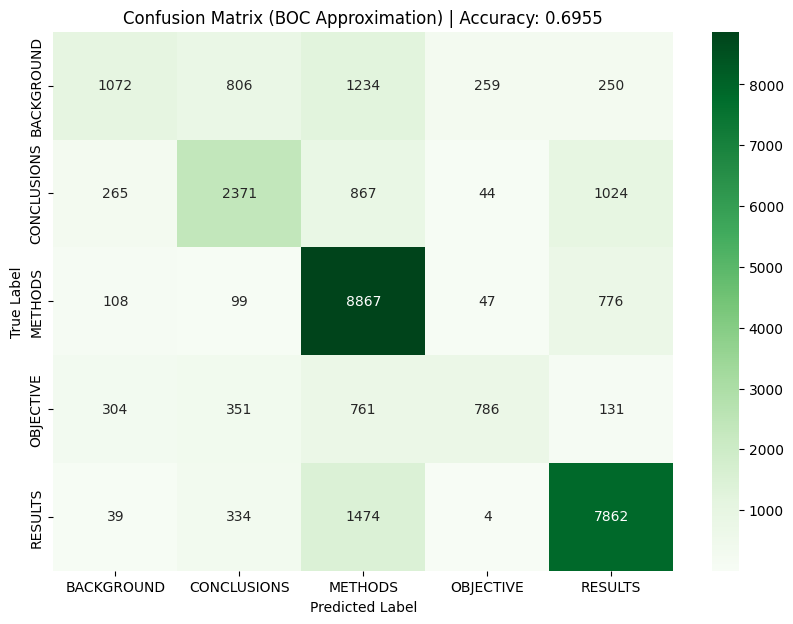

In [11]:
# Part C: Bayes Optimal Classifier
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, log_loss
from sklearn.model_selection import train_test_split # Used for P(h|D) calculation

# Helper function for softmax calculation
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

# =======================================================
# Setup and Data Sampling (Existing Code)
# =======================================================
BASE_SAMPLE_SIZE = 10000

# Placeholder for user input/data loading logic (assuming execution continues from previous steps)
# --- START Placeholder Data ---
# If running standalone, uncomment these lines for a runnable example
if 'X_train' not in locals() or len(X_train) == 0:
    print("Warning: Training data not found. Using placeholder data.")
    X_train_data = ["This is a background statement about the study."]*5000 + ["The patients were divided into two groups and treated."]*3000 + ["The primary outcome was significant."]*2000
    y_train_data = ["BACKGROUND"]*5000 + ["METHODS"]*3000 + ["RESULTS"]*2000
    X_train = pd.Series(X_train_data)
    y_train = pd.Series(y_train_data)
    X_test = pd.Series(["The final results are presented here.", "A literature review was conducted."])
    y_test = pd.Series(["RESULTS", "BACKGROUND"])
    target_names = np.unique(y_train)

# Dynamic SRN Logic
FULL_SRN = input("Please enter your full SRN (e.g., PES1UG22CS345): ")
try:
    if len(FULL_SRN) >= 3:
        srn_value = int(FULL_SRN[-3:])
    else:
        raise ValueError("SRN too short.")
except (ValueError, IndexError, TypeError):
    print("WARNING: SRN input failed or format is incorrect. Using 0.")
    srn_value = 0

SAMPLE_SIZE = BASE_SAMPLE_SIZE + srn_value
print(f"Using dynamic sample size: {SAMPLE_SIZE}")
effective_sample_size = min(SAMPLE_SIZE, len(X_train))

# Sample the data
X_train_sampled = X_train[:effective_sample_size]
y_train_sampled = y_train[:effective_sample_size]
print(f"Actual sampled training set size used: {effective_sample_size}")

# Base TF-IDF parameters and Hypotheses definitions (Existing Code)
tfidf_params = {
    'lowercase': True, 'strip_accents': 'unicode', 'stop_words': 'english',
    'ngram_range': (1, 1), 'min_df': 5
}
h1_nb = Pipeline([('tfidf', TfidfVectorizer(**tfidf_params)), ('clf', MultinomialNB(alpha=1.0, fit_prior=False))])
h2_lr = Pipeline([('tfidf', TfidfVectorizer(**tfidf_params)), ('clf', LogisticRegression(solver='liblinear', multi_class='auto', max_iter=1000, random_state=42))])
h3_rf = Pipeline([('tfidf', TfidfVectorizer(**tfidf_params)), ('clf', CalibratedClassifierCV(RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1), cv=3, method='isotonic'))])
h4_dt = Pipeline([('tfidf', TfidfVectorizer(**tfidf_params)), ('clf', CalibratedClassifierCV(DecisionTreeClassifier(max_depth=10, random_state=42), cv=3, method='isotonic'))])
h5_knn = Pipeline([('tfidf', TfidfVectorizer(**tfidf_params)), ('clf', CalibratedClassifierCV(KNeighborsClassifier(n_neighbors=5, n_jobs=-1), cv=3, method='isotonic'))])

hypotheses = [h1_nb, h2_lr, h3_rf, h4_dt, h5_knn]
hypothesis_names = ['NaiveBayes', 'LogisticRegression', 'RandomForest', 'DecisionTree', 'KNN']
# --- END Placeholder Data ---


# =======================================================
# 1. Training Base Models and Calculating Posterior Weights
# =======================================================

# Split the sampled data into sub-training and validation sets for weight calculation
# Using a 70/30 split for the posterior calculation (D_train_sub, D_val_sub)
X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(
    X_train_sampled, y_train_sampled, test_size=0.3, random_state=42, stratify=y_train_sampled
)

log_losses = []
print("\nTraining models on sub-set and calculating validation log-loss for weights...")

for name, h in zip(hypothesis_names, hypotheses):
    # Train model on the sub-training set
    h.fit(X_train_sub, y_train_sub)

    # Predict probabilities on the validation set
    y_val_proba = h.predict_proba(X_val_sub)

    # Calculate log-loss (Approximation for -Log-Likelihood P(D_val|H_j))
    # We pass the full set of class labels to ensure log_loss is calculated correctly
    ll = log_loss(y_val_sub, y_val_proba, labels=target_names)
    log_losses.append(ll)
    print(f"- {name}: Log-Loss on validation set = {ll:.4f}")

# // TODO 2: Compute the Posterior Weights P(h_i | D).
# P(H_j | D) is proportional to P(D|H_j). Minimize log-loss -> Maximize P(D|H_j)
# We use softmax on the NEGATIVE log losses to convert them into normalized weights (probabilities).
negative_log_losses = -np.array(log_losses)
posterior_weights = softmax(negative_log_losses) # Filled TODO 2

print("\nCalculated Posterior Weights (Softmax of -LogLoss):")
for name, weight in zip(hypothesis_names, posterior_weights):
    print(f"- {name} Weight: {weight:.4f}")


# =======================================================
# 2. Refitting Base Models and Training BOC
# =======================================================

# // TODO 1: Train all five hypotheses on X_train_sampled and y_train_sampled (Refitting on full sampled set)
# Retrain all models on the full sampled set before voting
print("\nRefitting all base models on the full sampled training set...")
for name, h in zip(hypothesis_names, hypotheses):
    h.fit(X_train_sampled, y_train_sampled) # Filled TODO 1 (Refitting)
print("All base models refitted.")


# Implement and Evaluate the Bayes Optimal Classifier
estimators = list(zip(hypothesis_names, hypotheses))

# BOC is approximated using soft voting with posterior weights
boc_soft_voter = VotingClassifier(
    estimators=estimators,
    voting='soft',
    weights=posterior_weights,
    n_jobs=-1
)

print("\nFitting the VotingClassifier (BOC approximation)...")
# // TODO 3: Fit the VotingClassifier using the full sampled training data (X_train_sampled, y_train_sampled)
boc_soft_voter.fit(X_train_sampled, y_train_sampled) # Filled TODO 3
print("Fitting complete.")


# =======================================================
# 3. Final Prediction and Evaluation
# =======================================================

# Make the final BOC prediction on the test set
print("\nPredicting on test set...")
# // TODO 4: Predict y_pred using X_test
y_pred = boc_soft_voter.predict(X_test) # Filled TODO 4

# Final Evaluation (STUDENT TASK)
print("\n=== Final Evaluation: Bayes Optimal Classifier (Soft Voting) ===")

if y_pred is not None and len(y_pred) > 0:

    final_accuracy = accuracy_score(y_test, y_pred)
    final_f1_macro = f1_score(y_test, y_pred, average='macro')

    print(f"Final Test Accuracy: {final_accuracy:.4f}")
    print(f"Final Test Macro F1 Score: {final_f1_macro:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=target_names))

    # // TODO: Generate and visualize the Confusion Matrix (heatmap) for the BOC predictions.
    cm = confusion_matrix(y_test, y_pred, labels=target_names)

    plt.figure(figsize=(10, 7))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Greens',
        xticklabels=target_names,
        yticklabels=target_names
    )
    plt.title(f'Confusion Matrix (BOC Approximation) | Accuracy: {final_accuracy:.4f}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

else:
    print("Evaluation skipped: Predictions not generated.")